In [1]:
import numpy as np
import uproot as up
from matplotlib import pyplot as plt

import utils

plt.rcParams.update({"figure.facecolor": "white", "figure.dpi": 90})
from scipy.linalg import cholesky, sqrtm
from scipy.optimize import minimize
from scipy.stats import norm, rv_histogram

In [2]:
# Data, pre and post fit from Jaafar
F = up.open("T2K_fit/chi2_MINERvA_CC0pinp_STV_XSec_1Ddpt_nu.root")
unfolded_h = F["MINERvA_CC0pinp_STV_XSec_1Ddpt_nu_data"].to_numpy()
bins = unfolded_h[1]
pre_fit_h = F["MINERvA_CC0pinp_STV_XSec_1Ddpt_nu_MC_prefit"].to_numpy()
post_fit_h = F["MINERvA_CC0pinp_STV_XSec_1Ddpt_nu_MC_postfit"].to_numpy()

# Express everything as the difference to the pre-fit model
# arr = unfolded_h[0]
# arr -= pre_fit_h[0]
# arr = post_fit_h[0]
# arr -= pre_fit_h[0]
# arr = pre_fit_h[0]
# arr -= pre_fit_h[0]

Text(0.5, 0, 'bin')

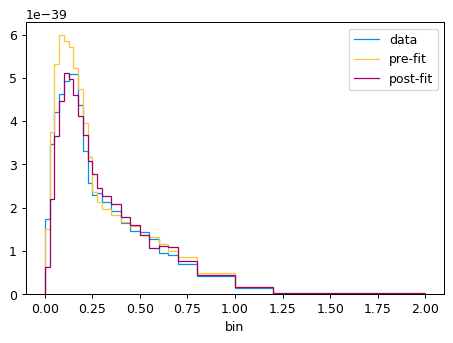

In [3]:
plt.stairs(*unfolded_h, label="data")
plt.stairs(*pre_fit_h, label="pre-fit")
plt.stairs(*post_fit_h, label="post-fit")
plt.legend()
plt.xlabel("bin")

In [4]:
# Error bars
F = up.open("T2K_fit/chi2_MINERvA_CC0pinp_STV_XSec_1Ddpt_nu.root")
cov_unfolded = F["MINERvA_CC0pinp_STV_XSec_1Ddpt_nu_cov"].to_numpy()[0]
cor_unfolded = cov_unfolded / (
    np.sqrt(np.diag(cov_unfolded))[:, None] * np.sqrt(np.diag(cov_unfolded))[None, :]
)
cov_unfolded_inv = np.linalg.inv(cov_unfolded)
cor_unfolded[~np.isfinite(cor_unfolded)] = 0

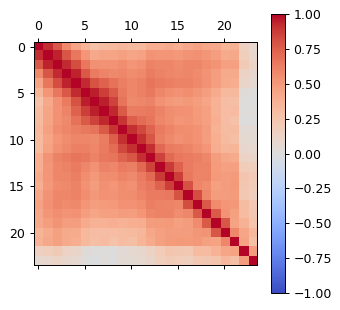

In [5]:
plt.matshow(cor_unfolded, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

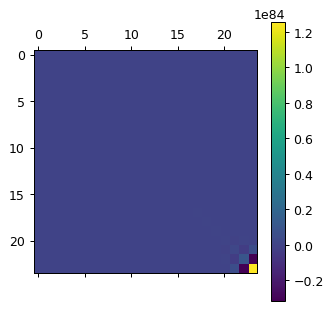

In [6]:
# Regularisation
C = utils.Q2s(post_fit_h[0]) * 1e80
plt.matshow(C)
plt.colorbar()

In [7]:
# Regularised result
#
# m' = A m
# A = (cov^{-1} + C)^-1 cov^{-1}

diff = unfolded_h[0] - pre_fit_h[0]
chi2 = diff.T @ cov_unfolded_inv @ diff
tau_inv = pre_fit_h[0].T @ C @ pre_fit_h[0]
tau_max = chi2 / tau_inv
print(chi2, tau_inv, tau_max)

tau_list = [0.0] + list(np.logspace(-2, 0.5, 5))
A_list = [
    np.linalg.inv(cov_unfolded_inv + tau * C) @ cov_unfolded_inv for tau in tau_list
]
regularised_list = [A @ unfolded_h[0] for A in A_list]

100.87411035998912 425.5917899364062 0.23702080901293274


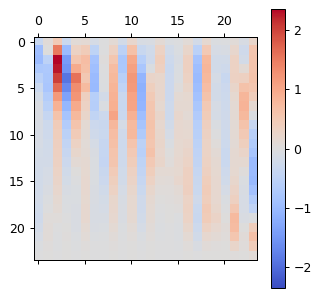

In [8]:
plt.matshow(A_list[-1], cmap="coolwarm", vmin=-np.max(A_list[-1]))
plt.colorbar()

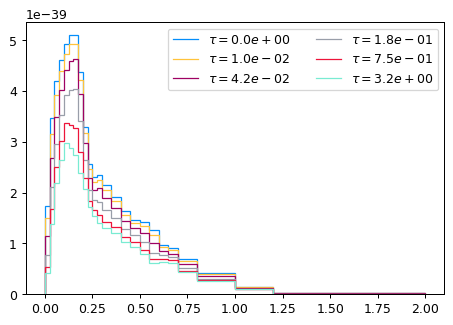

In [9]:
for x, tau in zip(regularised_list, tau_list):
    plt.stairs(x, bins, label=rf"$\tau = {tau:3.1e}$")
plt.legend(ncol=2)

In [10]:
# Metrics
jaggedness = [x.T @ C @ x for x in regularised_list]
bias = [
    (x - unfolded_h[0]).T @ cov_unfolded_inv @ (x - unfolded_h[0])
    for x in regularised_list
]

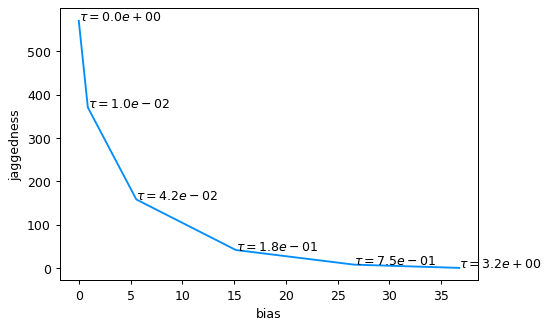

In [11]:
plt.plot(bias, jaggedness)
plt.xlabel("bias")
plt.ylabel("jaggedness")
for x, y, tau in zip(bias, jaggedness, tau_list):
    plt.annotate(rf"$\tau = {tau:.1e}$", (x, y))

In [12]:
# Alt metrics
# Determinant of covariance/correlation matrix as measure of overall correlation?
cov_list = [A @ cov_unfolded @ A.T for A in A_list]
cor_list = [
    np.diag(np.diag(cov) ** (-0.5)) @ cov @ np.diag(np.diag(cov) ** (-0.5))
    for cov in cov_list
]
cov_det_list = [np.linalg.det(cov) for cov in cov_list]
cor_det_list = [np.linalg.det(cor) for cor in cor_list]

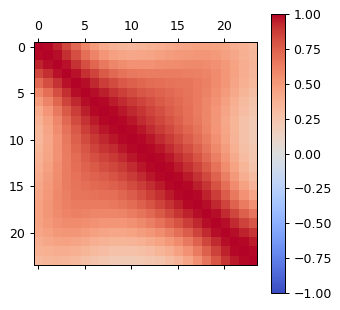

In [13]:
plt.matshow(cor_list[-1], cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

In [14]:
# Alt metrics
# Wasserstein distance in uncorrelated standard normal space
# The Fréchet distance between multivariate normal distributions
# https://doi.org/10.1016/0047-259X(82)90077-X
dist = []
diag_dist = []


def wasserstein(x, cov, base_x=unfolded_h[0], base_cov=cov_unfolded):
    U = cholesky(np.linalg.inv(base_cov))
    m = U @ base_x
    diff = m - U @ x
    S = U @ cov @ U.T
    d = diff.T @ diff + cov.shape[0] + np.trace(S - 2 * sqrtm(S))
    return abs(d)  # Catch some numerical issues


for x, cov in zip(regularised_list, cov_list):
    # Distance between original and regularised
    dist.append(wasserstein(x, cov))
    # Distance between original and plot
    diag_dist.append(wasserstein(x, np.diag(np.diag(cov))))

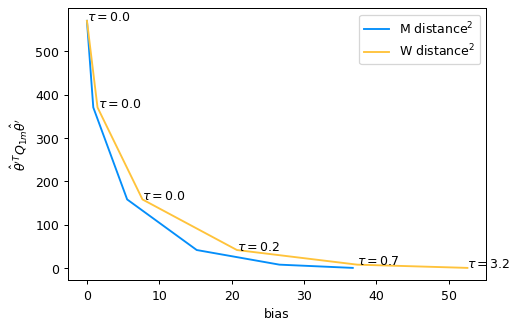

In [15]:
plt.plot(bias, jaggedness, label="M distance$^2$")
plt.plot(dist, jaggedness, label="W distance$^2$")
plt.legend()
plt.xlabel("bias")
plt.ylabel(r"${\hat\theta}'^T Q_{1m} {\hat\theta}'$")
for x, y, tau in zip(dist, jaggedness, tau_list):
    plt.annotate(rf"$\tau = {tau:.1f}$", (x, y))

5 3.1622776601683795 222.89765344206856 14.92975731356905


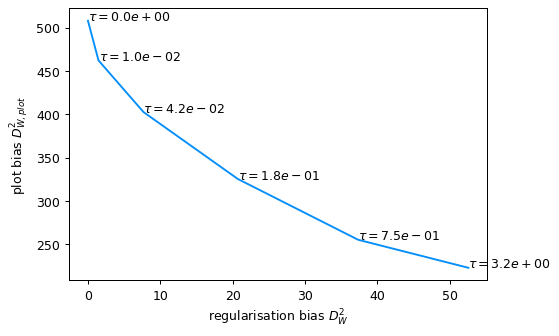

In [16]:
plt.plot(dist, diag_dist)
plt.xlabel("regularisation bias $D^2_W$")
plt.ylabel("plot bias $D^2_{W,plot}$")
i_W = 0
best = np.inf
for i, (x, y, tau) in enumerate(zip(dist, diag_dist, tau_list)):
    plt.annotate(rf"$\tau = {tau:.1e}$", (x, y))
    if y < best:
        best = y
        i_W = i
print(i_W, tau_list[i_W], best, np.sqrt(best))

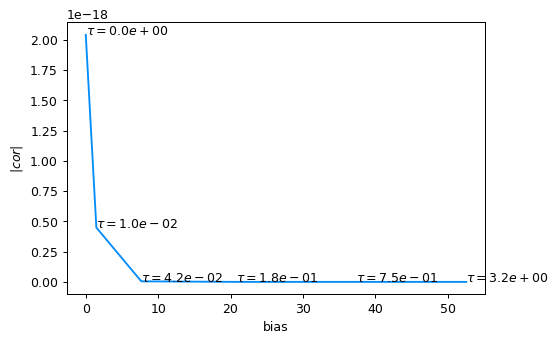

In [17]:
plt.plot(dist, cor_det_list)
plt.xlabel("bias")
plt.ylabel(r"$|cor|$")
i_D = 0
best = 0
for i, (x, y, tau) in enumerate(zip(dist, cor_det_list, tau_list)):
    plt.annotate(rf"$\tau = {tau:.1e}$", (x, y))
    if y > best:
        best = y
        i_D = i

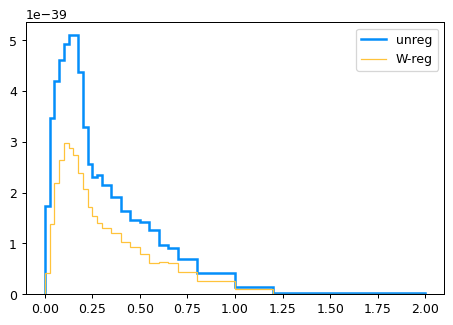

In [18]:
plt.stairs(*unfolded_h, label="unreg", linewidth=2)
plt.stairs(regularised_list[i_W], bins, label="W-reg")
plt.legend()

In [19]:
# Minimal possible plot bias
def fun(x):
    return wasserstein(unfolded_h[0], np.diag(x))


ret = minimize(fun, x0=np.diag(cov_unfolded))
best_error = np.sqrt(ret.x)

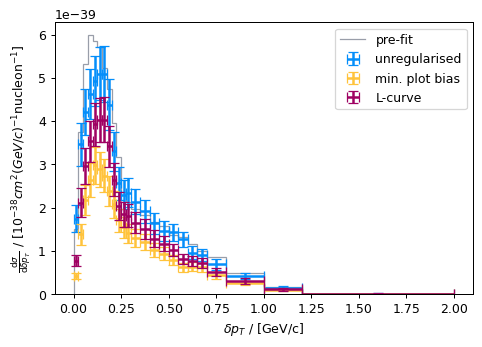

In [20]:
x = (bins[:-1] + bins[1:]) / 2
xerr = (bins[1:] - bins[:-1]) / 2

y = unfolded_h[0]
yerr = np.sqrt(np.diag(cov_unfolded))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="unregularised",
    linewidth=2,
    linestyle="",
    capsize=4,
)

y = regularised_list[i_W]
yerr = np.sqrt(np.diag(cov_list[i_W]))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="min. plot bias",
    linewidth=2,
    linestyle="",
    capsize=4,
)


y = regularised_list[3]
yerr = np.sqrt(np.diag(cov_list[3]))
plt.errorbar(
    x,
    y,
    yerr=yerr,
    xerr=xerr,
    label="L-curve",
    linewidth=2,
    linestyle="",
    capsize=4,
)
# y = unfolded_h[0]
# yerr = best_error
# plt.errorbar(
#    x, y, yerr=yerr, xerr=xerr, label="best possible", linewidth=1, linestyle="", capsize=4
# )

plt.stairs(*pre_fit_h, label="pre-fit")
plt.xlabel(r"$\delta p_T$ / [GeV/c]")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ [10^{-38} cm^2 (GeV/c)^{-1} \mathrm{nucleon}^{-1}]$"
)
plt.legend()

-0.005731197494177283 53.6470606740707


Text(0, 0.5, '$\\frac{\\mathrm{d}\\sigma}{\\mathrm{d}\\delta p_T}\\ /\\ \\frac{\\mathrm{d}\\sigma_\\mathrm{MC,pre-fit}}{\\mathrm{d}\\delta p_T}$')

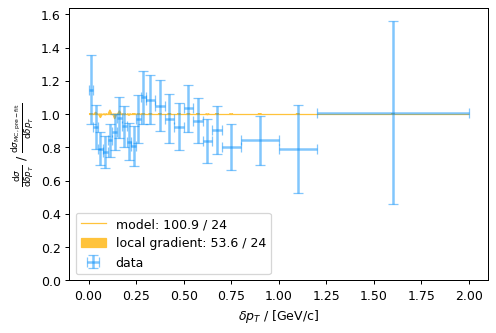

In [21]:
utils.model_ratio_plot(
    # pre_fit_h[0], regularised_list[i_W], cov_list[i_W], A_list[i_W], bins=bins, data_label="data"
    pre_fit_h[0],
    regularised_list[0],
    cov_list[0],
    A_list[0],
    bins=bins,
    data_label="data",
)
plt.xlabel(r"$\delta p_T$ / [GeV/c]")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ \frac{\mathrm{d}\sigma_\mathrm{MC,pre-fit}}{\mathrm{d}\delta p_T}$"
)

-0.005731197494177283 53.6470606740707


(0.0, 0.7)

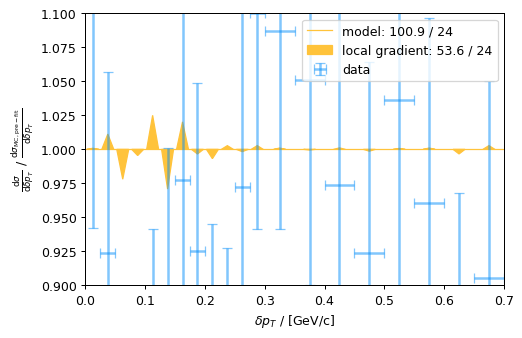

In [22]:
utils.model_ratio_plot(
    # pre_fit_h[0], regularised_list[i_W], cov_list[i_W], A_list[i_W], bins=bins, data_label="data"
    pre_fit_h[0],
    regularised_list[0],
    cov_list[0],
    A_list[0],
    bins=bins,
    data_label="data",
)
plt.xlabel(r"$\delta p_T$ / [GeV/c]")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ \frac{\mathrm{d}\sigma_\mathrm{MC,pre-fit}}{\mathrm{d}\delta p_T}$"
)
plt.ylim(0.9, 1.1)
plt.xlim(0.0, 0.7)

-0.01025642794392518 55.887948381481564


Text(0, 0.5, '$\\frac{\\mathrm{d}\\sigma}{\\mathrm{d}\\delta p_T}\\ /\\ \\frac{\\mathrm{d}\\sigma_\\mathrm{MC,post-fit}}{\\mathrm{d}\\delta p_T}$')

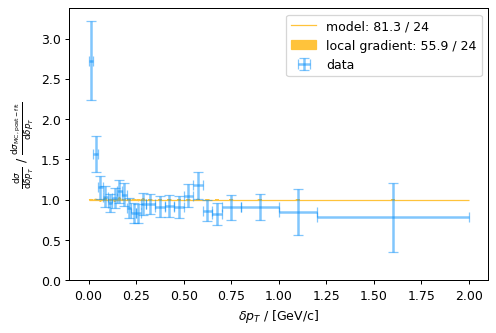

In [23]:
utils.model_ratio_plot(
    # post_fit_h[0], regularised_list[i_W], cov_list[i_W], A_list[i_W], bins=bins, data_label="data"
    post_fit_h[0],
    regularised_list[0],
    cov_list[0],
    A_list[0],
    bins=bins,
    data_label="data",
)
plt.xlabel(r"$\delta p_T$ / [GeV/c]")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ \frac{\mathrm{d}\sigma_\mathrm{MC,post-fit}}{\mathrm{d}\delta p_T}$"
)

-0.01025642794392518 55.887948381481564


Text(0, 0.5, '$\\Delta D^2_M$')

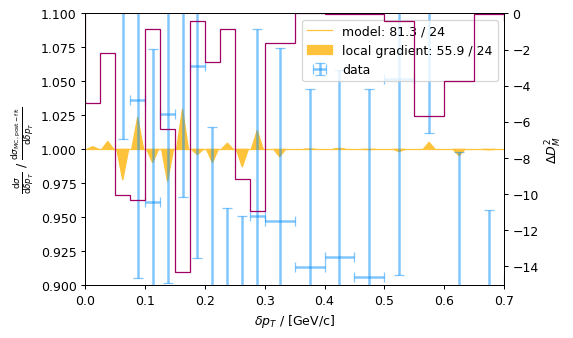

In [24]:
grad = utils.model_ratio_plot(
    # post_fit_h[0], regularised_list[i_W], cov_list[i_W], A_list[i_W], bins=bins, data_label="data"
    post_fit_h[0],
    regularised_list[0],
    cov_list[0],
    A_list[0],
    bins=bins,
    data_label="data",
)
plt.xlabel(r"$\delta p_T$ / [GeV/c]")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ \frac{\mathrm{d}\sigma_\mathrm{MC,post-fit}}{\mathrm{d}\delta p_T}$"
)
plt.ylim(0.9, 1.1)
plt.xlim(0.0, 0.7)

ax = plt.twinx()

# N-1 plots
orig_chi2 = utils.chi2(post_fit_h[0], unfolded_h[0], cov_unfolded_inv)
mod_chi2 = []
for i in range(len(unfolded_h[0])):
    d = np.delete(unfolded_h[0], i)
    m = np.delete(post_fit_h[0], i)
    c = np.delete(cov_unfolded, i, axis=0)
    c = np.delete(c, i, axis=1)
    ci = np.linalg.inv(c)
    mod_chi2.append(utils.chi2(m, d, ci))
mod_chi2 = np.array(mod_chi2)

ax.stairs(mod_chi2 - orig_chi2, bins, color="C2")
ax.set_ylabel(r"$\Delta D^2_M$")

Text(0, 0.5, '$\\Delta D^2_M$')

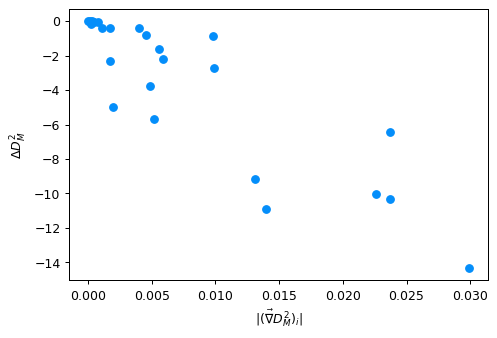

In [25]:
plt.scatter(np.abs(grad), mod_chi2 - orig_chi2)
plt.xlabel(r"$|(\vec\nabla D^2_M)_i|$")
plt.ylabel(r"$\Delta D^2_M$")

56.10736445871206
-0.015119357803182765 29.06682323298877


(0.0, 0.7)

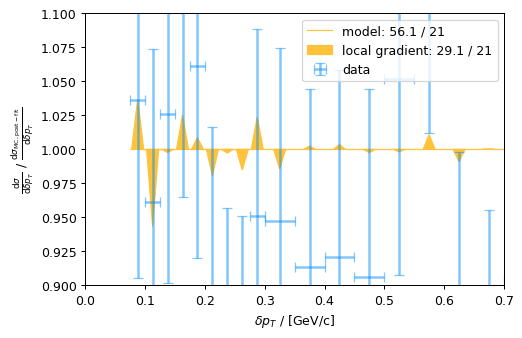

In [42]:
# Remove first three bins
i = [0, 1, 2]
b = np.delete(bins, i)
d = np.delete(unfolded_h[0], i)
m = np.delete(post_fit_h[0], i)
c = np.delete(cov_unfolded, i, axis=0)
c = np.delete(c, i, axis=1)
ci = np.linalg.inv(c)
print(utils.chi2(m, d, ci))

grad = utils.model_ratio_plot(
    m,
    d,
    c,
    bins=b,
    data_label="data",
)
plt.xlabel(r"$\delta p_T$ / [GeV/c]")
plt.ylabel(
    r"$\frac{\mathrm{d}\sigma}{\mathrm{d}\delta p_T}\ /\ \frac{\mathrm{d}\sigma_\mathrm{MC,post-fit}}{\mathrm{d}\delta p_T}$"
)
plt.ylim(0.9, 1.1)
plt.xlim(0.0, 0.7)